# 第8章 方差分析

## 初始化

In [1]:
# 本章需要用到的库
import numpy as np # 导入numpy库
import pandas as pd # 导入pandas库
import matplotlib.pyplot as plt # 导入matplotlib库
import seaborn as sns # 导入seaborn库
from scipy.stats import shapiro, kstest # 导入正态性检验函数: S-W检验和K-S检验
from scipy.stats import bartlett, levene # 导入方差齐性检验函数: Bartlett检验和Levene检验
import statsmodels.api as sm # 导入statsmodels库
from statsmodels.formula.api import ols # 导入普通最小二乘法函数
from statsmodels.stats.anova import anova_lm # 导入方差分析函数
from statsmodels.stats.multicomp import MultiComparison # 导入多重比较函数
from statsmodels.graphics.api import interaction_plot # 导入交互作用图函数

# 设置初始化
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

## 8.1 方差分析的原理

### 8.1.1 什么是方差分析

### 8.1.2 误差分解

## 8.2 单因子方差分析

### 8.2.1 数学模型

### 8.2.2 效应检验

In [3]:
example8_1 = pd.read_csv('./pydata/chap08/example8_1.csv', encoding='gbk') # 读取数据
example8_1

,品种1,品种2,品种3
0,81,71,76
1,82,72,79
2,79,72,77
3,81,66,76
4,78,72,78
5,89,77,89
6,92,81,87
7,87,77,84
8,85,73,87
9,86,79,87


In [7]:
example8_2 = pd.melt(
    example8_1, value_vars=['品种1', '品种2', '品种3'], 
    var_name='品种', value_name='产量'
) # 转换数据格式
example8_2.to_csv('./pydata/chap08/example8_2.csv', encoding='gbk', index=False) # 保存数据
example8_2.head() # 显示前5行数据

,品种,产量
0,品种1,81
1,品种1,82
2,品种1,79
3,品种1,81
4,品种1,78


提出假设：
- $H_0: \alpha_1 = \alpha_2 = \alpha_3 = 0$(品种对产量的影响不显著)
- $H_1: \alpha_1, \alpha_2, \alpha_3$ 至少有一个不等于0(品种对产量的影响显著)

In [9]:
example8_2 = pd.read_csv('./pydata/chap08/example8_2.csv', encoding='gbk') # 读取数据
model = ols('产量 ~ 品种', data=example8_2).fit() # 拟合方差分析模型
anova_lm(model, typ=1) # 执行方差分析

,df,sum_sq,mean_sq,F,PR(>F)
品种,2.0,560.0,280.000000,12.312704,0.000158
Residual,27.0,614.0,22.740741,NaN,NaN


In [10]:
model.summary() # 显示方差分析结果

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     产量   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     12.31
Date:                Sun, 14 May 2023   Prob (F-statistic):           0.000158
Time:                        19:36:42   Log-Likelihood:                -87.850
No. Observations:                  30   AIC:                             181.7
Df Residuals:                      27   BIC:                             185.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.0000      1.508     55.703      0.000      80.906      87.094
品种[T.品种2]    -10.0000      2.133     -4.689      0.000     -14.376      -5.624
品种[T.品种3]     -2.0000      2.133     -0.938      0.357      -6.376       2.376
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                1.968
Skew:                           0.110   Prob(JB):                        0.374
Kurtosis:                       1.765   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

由于P<0.05, 所以拒绝原假设。

In [16]:
model.conf_int()

,0,1
Intercept,80.905833,87.094167
品种[T.品种2],-14.375813,-5.624187
品种[T.品种3],-6.375813,2.375813


In [17]:
mean = model.params.values[0] # 品种1(参照的基础水平)的平均产量
lci, uci = model.conf_int().iloc[0].values # 品种1(参照的基础水平)的置信区间
df_mean = pd.DataFrame([lci, mean, uci], index=['lci', 'mean', 'uci'], columns=['品种1']) # 构建数据框
df_mean['品种2'] = df_mean['品种1'] + model.params.values[1] # 品种2的平均产量
df_mean['品种3'] = df_mean['品种1'] + model.params.values[2] # 品种3的平均产量
df_mean

,品种1,品种2,品种3
lci,80.905833,70.905833,78.905833
mean,84.000000,74.000000,82.000000
uci,87.094167,77.094167,85.094167


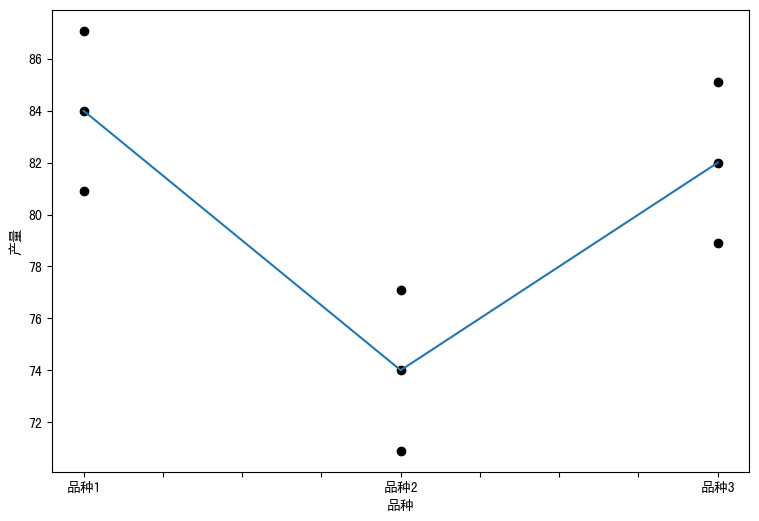

In [19]:
ax = df_mean.T.plot(
    ls='', marker='o', legend=False, c='black', 
    figsize=(9, 6), xlabel='品种', ylabel='产量'
) # 绘制图形
ax = df_mean.T['mean'].plot()

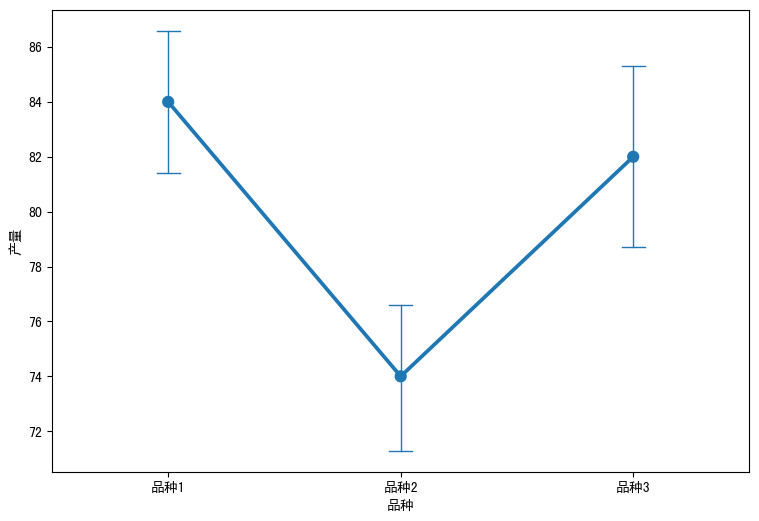

In [25]:
plt.figure(figsize=(9, 6)) # 设置图形大小
sns.pointplot(
    x='品种', y='产量', data=example8_2,
    capsize=.1, errwidth=1
)
plt.xlabel('品种') # 添加横轴标签
plt.ylabel('产量') # 添加纵轴标签
plt.show() # 显示图形

### 8.2.3 效应量分析

In [27]:
# 效应量分析，接上例8-2中的模型
print(f'效应量为 {model.rsquared:.4g}') # 显示效应量

效应量为 0.477


在产量取值的总误差中被品种解释的比例为47.7%。

### 8.2.4 多重比较

In [30]:
mc = MultiComparison(example8_2['产量'], example8_2['品种']) # 创建多重比较对象
mc.tukeyhsd(alpha=0.05).summary() # 执行多重比较

group1,group2,meandiff,p-adj,lower,upper,reject
品种1,品种2,-10.0,0.0002,-15.2877,-4.7123,True
品种1,品种3,-2.0,0.6216,-7.2877,3.2877,False
品种2,品种3,8.0,0.0024,2.7123,13.2877,True


结果显示，品种3与品种1之间的差异不显著，品种1与品种2、品种3与品种2之间的差异均显著。

## 8.3 双因子方差分析

### 8.3.1 数学模型

### 8.3.2 主效应分析

检验因子A的假设：
- $H_0: \alpha_i = 0, (i=1,2,\cdots,I)$ (因子A的处理效应不显著)
- $H_1: \alpha_i$ 至少有一个不等于0 (因子A的处理效应显著)

检验因子B的假设：
- $H_0: \beta_j = 0, (j=1,2,\cdots,J)$ (因子B的处理效应不显著)
- $H_1: \beta_j$ 至少有一个不等于0 (因子B的处理效应显著)

In [40]:
table8_4 = pd.read_csv('./pydata/chap08/table8_4.csv', encoding='gbk') # 读取数据
table8_4

,施肥方式,品种1,品种2,品种3
0,甲,81,71,76
1,甲,82,72,79
2,甲,79,72,77
3,甲,81,66,76
4,甲,78,72,78
5,乙,89,77,89
6,乙,92,81,87
7,乙,87,77,84
8,乙,85,73,87
9,乙,86,79,87


In [41]:
example8_4 = pd.melt(
    table8_4, id_vars=['施肥方式'],
    value_vars=['品种1', '品种2', '品种3'],
    var_name='品种', value_name='产量'
) # 转换数据格式
example8_4.to_csv('./pydata/chap08/example8_4.csv', encoding='gbk', index=False) # 保存数据
example8_4.head() # 显示前5行数据

,施肥方式,品种,产量
0,甲,品种1,81
1,甲,品种1,82
2,甲,品种1,79
3,甲,品种1,81
4,甲,品种1,78


In [42]:
model2m = ols('产量 ~ 品种 + 施肥方式', data=example8_4).fit() # 拟合方差分析模型
anova_lm(model2m, typ=1) # 执行方差分析

,df,sum_sq,mean_sq,F,PR(>F)
品种,2.0,560.0,280.000000,54.328358,5.184290e-10
施肥方式,1.0,480.0,480.000000,93.134328,4.422633e-10
Residual,26.0,134.0,5.153846,NaN,NaN


In [43]:
model2m.summary() # 显示方差分析结果

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     产量   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     67.26
Date:                Sun, 14 May 2023   Prob (F-statistic):           2.21e-12
Time:                        20:05:35   Log-Likelihood:                -65.018
No. Observations:                  30   AIC:                             138.0
Df Residuals:                      26   BIC:                             143.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     88.0000      0.829    106.157      0.000      86.296      89.704
品种[T.品种2]    -10.0000      1.015     -9.850      0.000     -12.087      -7.913
品种[T.品种3]     -2.0000      1.015     -1.970      0.060      -4.087       0.087
施肥方式[T.甲]     -8.0000      0.829     -9.651      0.000      -9.704      -6.296
==============================================================================
Omnibus:                        0.889   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.880
Skew:                          -0.360   Prob(JB):                        0.644
Kurtosis:                       2.570   Cond. No.                         4.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

检验品种和施肥方式两个因子的P值均接近于0，表示两个因子对产量均有显著影响。

In [47]:
# 计算主效应方差分析的效应量
df_res = anova_lm(model2m, typ=1) # 执行方差分析
df_res['eta_sq'] = df_res['sum_sq'] / df_res['sum_sq'].sum() # 计算主效应量
df_res['eta_sq_part'] = df_res['sum_sq'] / (df_res['sum_sq'] + df_res.loc['Residual', 'sum_sq']) # 计算偏效应量
df_res.loc['Residual', 'eta_sq_part'] = np.nan
df_res

,df,sum_sq,mean_sq,F,PR(>F),eta_sq,eta_sq_part
品种,2.0,560.0,280.000000,54.328358,5.184290e-10,0.477002,0.806916
施肥方式,1.0,480.0,480.000000,93.134328,4.422633e-10,0.408859,0.781759
Residual,26.0,134.0,5.153846,NaN,NaN,0.114140,NaN


偏效应分析结果表明：
- 在排除施肥方式的影响后，品种因子解释了产量误差的80.69%
- 在排除品种的影响后，施肥方式因子解释了产量误差的78.18%

主效应分析结果表明：
- 品种因子单独解释了产量误差的47.70%
- 施肥方式因子单独解释了产量误差的40.89%

联合效应分析结果表明：
- 将品种主效应量和施肥方式主效应量相加，得到的联合效应量为0.4770+0.4089=0.8859，表明品种和施肥方式两个因子联合起来总共解释产量误差的88.59%。

### 8.3.3 交互效应分析

检验交互效应的假设：
- $H_0: \gamma_{ij} = 0, (i=1,2,\cdots,I; j=1,2,\cdots,J)$ (交互效应不显著)
- $H_1: \gamma_{ij}$ 至少有一个不等于0 (交互效应显著)

In [48]:
model2i = ols('产量 ~ 品种 + 施肥方式 + 品种:施肥方式', data=example8_4).fit() # 拟合方差分析模型
anova_lm(model2i, typ=1) # 执行方差分析

,df,sum_sq,mean_sq,F,PR(>F)
品种,2.0,560.0,280.00,54.368932,1.220666e-09
施肥方式,1.0,480.0,480.00,93.203883,9.729467e-10
品种:施肥方式,2.0,10.4,5.20,1.009709,3.792836e-01
Residual,24.0,123.6,5.15,NaN,NaN


In [49]:
model2i.summary() # 显示方差分析结果

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     产量   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     40.79
Date:                Sun, 14 May 2023   Prob (F-statistic):           5.77e-11
Time:                        20:19:59   Log-Likelihood:                -63.806
No. Observations:                  30   AIC:                             139.6
Df Residuals:                      24   BIC:                             148.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              87.8000      1.015     86.512      0.000      85.705      89.895
品种[T.品种2]             -10.4000      1.435     -7.246      0.000     -13.362      -7.438
品种[T.品种3]              -1.0000      1.435     -0.697      0.493      -3.962       1.962
施肥方式[T.甲]              -7.6000      1.435     -5.295      0.000     -10.562      -4.638
品种[T.品种2]:施肥方式[T.甲]     0.8000      2.030      0.394      0.697      -3.389       4.989
品种[T.品种3]:施肥方式[T.甲]    -2.0000      2.030     -0.985      0.334      -6.189       2.189
==============================================================================
Omnibus:                        1.127   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.569   Jarque-Bera (JB):                0.644
Skew:                          -0.359   Prob(JB):                        0.725
Kurtosis:                       3.007   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

检验交互效应的P=0.379，大于0.05，表示交互效应对产量的影响不显著。

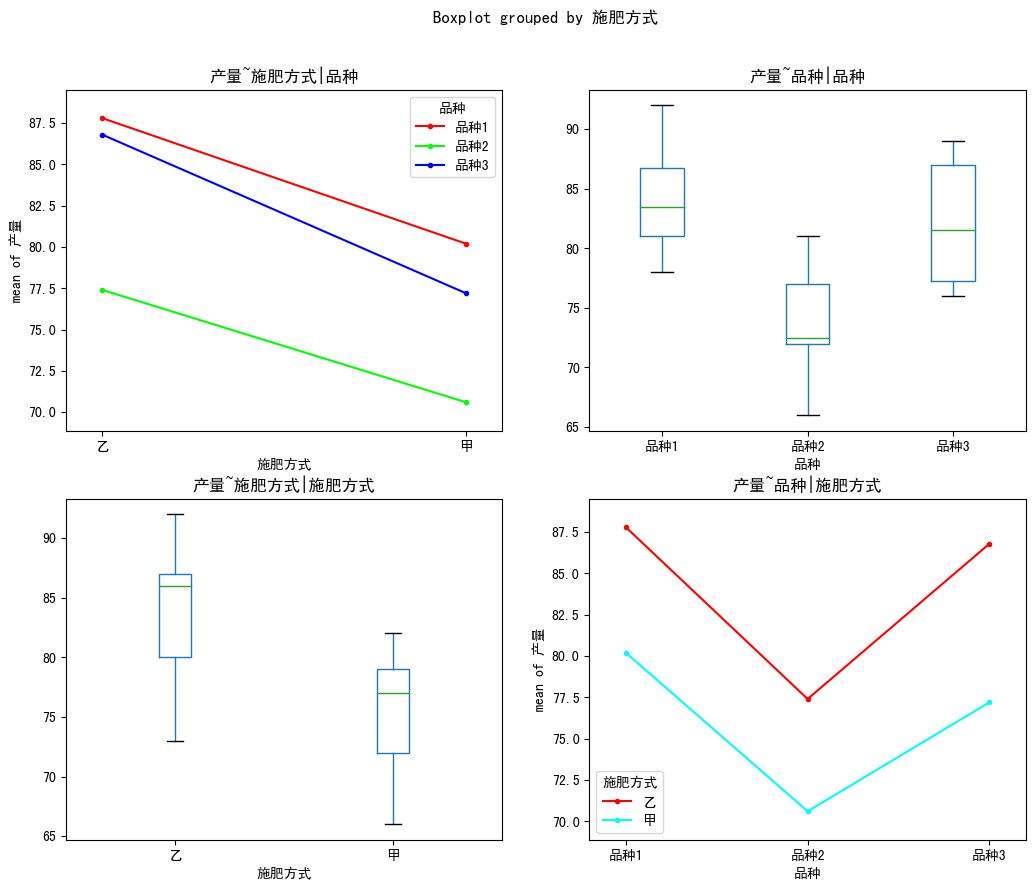

In [55]:
y_col = '产量' # 因变量列名
x1_col = '品种' # 自变量列名
x2_col = '施肥方式' # 自变量列名

plt.subplots(2, 2, figsize=(12, 10)) # 设置图形大小

ax1 = plt.subplot(221) # 创建子图1
interaction_plot(
    x=example8_4[x2_col], trace=example8_4[x1_col], response=example8_4[y_col],
    xlabel=x2_col, ylabel=y_col, ax=ax1
) # 绘制交互作用图
ax1.set_title(f'{y_col}~{x2_col}|{x1_col}') # 添加子图标题

ax2 = plt.subplot(222) # 创建子图2
example8_4.boxplot(column=y_col, by=x1_col, grid=False, ax=ax2) # 绘制箱线图
ax2.set_title(f'{y_col}~{x1_col}|{x1_col}') # 添加子图标题

ax3 = plt.subplot(223) # 创建子图3
example8_4.boxplot(column=y_col, by=x2_col, grid=False, ax=ax3) # 绘制箱线图
ax3.set_title(f'{y_col}~{x2_col}|{x2_col}') # 添加子图标题

ax4 = plt.subplot(224) # 创建子图4
interaction_plot(
    x=example8_4[x1_col], trace=example8_4[x2_col], response=example8_4[y_col],
    xlabel=x1_col, ylabel=y_col, ax=ax4
) # 绘制交互作用图
ax4.set_title(f'{y_col}~{x1_col}|{x2_col}') # 添加子图标题

plt.show() # 显示图形

In [56]:
# 交互效应方差分析的效应量
df_res = anova_lm(model2i, typ=1) # 执行方差分析
df_res['eta_sq'] = df_res['sum_sq'] / df_res['sum_sq'].sum() # 计算主效应量
df_res['eta_sq_part'] = df_res['sum_sq'] / (df_res['sum_sq'] + df_res.loc['Residual', 'sum_sq']) # 计算偏效应量
df_res.loc['Residual', 'eta_sq_part'] = np.nan
df_res

,df,sum_sq,mean_sq,F,PR(>F),eta_sq,eta_sq_part
品种,2.0,560.0,280.00,54.368932,1.220666e-09,0.477002,0.819193
施肥方式,1.0,480.0,480.00,93.203883,9.729467e-10,0.408859,0.795229
品种:施肥方式,2.0,10.4,5.20,1.009709,3.792836e-01,0.008859,0.077612
Residual,24.0,123.6,5.15,NaN,NaN,0.105281,NaN


偏效应分析结果表明：
- 在排除施肥方式和交互效应的影响后，品种因子解释了产量误差的81.92%
- 在排除品种和交互效应的影响后，施肥方式因子解释了产量误差的79.52%
- 在排除品种和施肥方式的影响后，交互效应解释了产量误差的7.76%

## 8.4 方差分析的假定及其检验

### 8.4.1 正态性检验

In [58]:
example8_1 = pd.read_csv('./pydata/chap08/example8_1.csv', encoding='gbk') # 读取数据
example8_1

,品种1,品种2,品种3
0,81,71,76
1,82,72,79
2,79,72,77
3,81,66,76
4,78,72,78
5,89,77,89
6,92,81,87
7,87,77,84
8,85,73,87
9,86,79,87


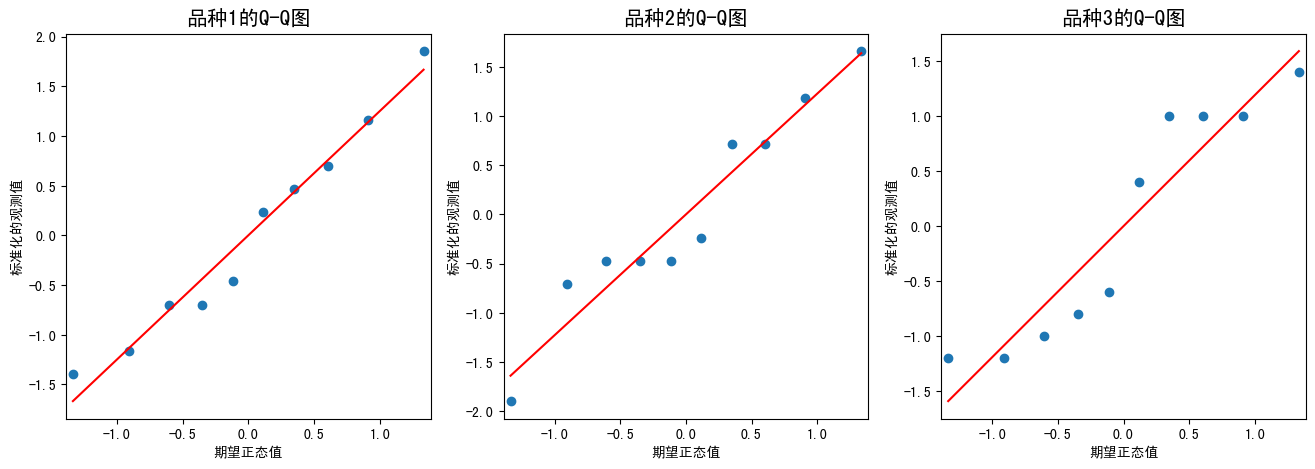

In [59]:
# 每个品种产量的正态Q-Q图
plt.subplots(1, 3, figsize=(16, 5)) # 设置图形大小

ax1 = plt.subplot(131) # 创建子图1
pplot_1 = sm.ProbPlot(example8_1['品种1'], fit=True) # 创建概率图对象
pplot_1.qqplot(line='r', ax=ax1, xlabel='期望正态值', ylabel='标准化的观测值') # 绘制概率图
ax1.set_title('品种1的Q-Q图', fontsize=15) # 添加子图标题

ax2 = plt.subplot(132) # 创建子图2
ppplot_2 = sm.ProbPlot(example8_1['品种2'], fit=True) # 创建概率图对象
ppplot_2.qqplot(line='r', ax=ax2, xlabel='期望正态值', ylabel='标准化的观测值') # 绘制概率图
ax2.set_title('品种2的Q-Q图', fontsize=15) # 添加子图标题

ax3 = plt.subplot(133) # 创建子图3
ppplot_3 = sm.ProbPlot(example8_1['品种3'], fit=True) # 创建概率图对象
ppplot_3.qqplot(line='r', ax=ax3, xlabel='期望正态值', ylabel='标准化的观测值') # 绘制概率图
ax3.set_title('品种3的Q-Q图', fontsize=15) # 添加子图标题

plt.show() # 显示图形

In [61]:
example8_2 = pd.read_csv('./pydata/chap08/example8_2.csv', encoding='gbk') # 读取数据
example8_2.head() # 显示前5行数据

,品种,产量
0,品种1,81
1,品种1,82
2,品种1,79
3,品种1,81
4,品种1,78


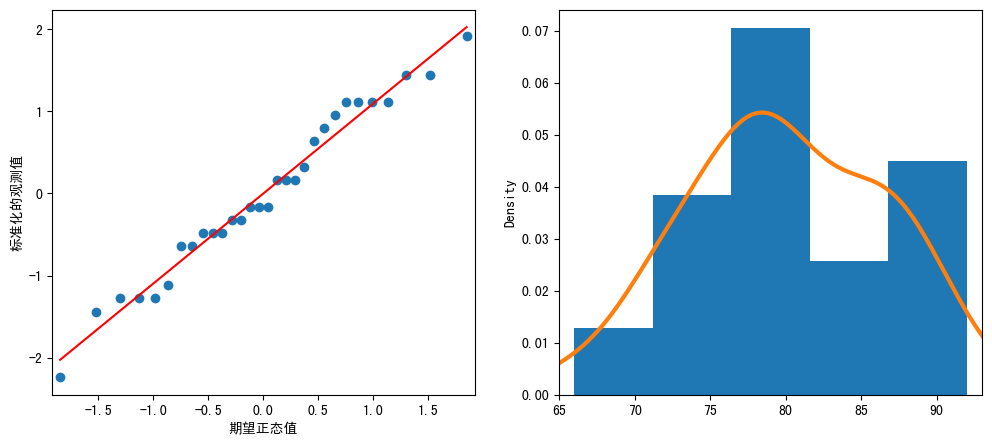

In [62]:
# 3个品种产量数据合并后的正态Q-Q图、直方图及核密度曲线
plt.subplots(1, 2, figsize=(12, 5)) # 设置图形大小

ax1 = plt.subplot(121) # 创建子图1
pplot = sm.ProbPlot(example8_2['产量'], fit=True) # 创建概率图对象
pplot.qqplot(line='r', ax=ax1, xlabel='期望正态值', ylabel='标准化的观测值') # 绘制概率图

ax2 = plt.subplot(122) # 创建子图2
example8_2['产量'].plot(kind='hist', bins=5, ax=ax2, density=True, legend=False) # 绘制直方图
example8_2['产量'].plot(kind='density', ax=ax2, linewidth=3) # 绘制核密度曲线
ax2.set_xlim(65, 93)

plt.show() # 显示图形

提出假设：
- $H_0:$ 产量服从正态分布
- $H_1:$ 产量不服从正态分布

In [64]:
W, p_value = shapiro(example8_2['产量']) # 执行S-W检验
print(f'统计量W={W:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量W=0.97299, p值=0.6237


In [65]:
D, p_value = kstest(
    example8_2['产量'], 'norm', alternative='two-sided', mode='asymp',
    args=(example8_2['产量'].mean(), example8_2['产量'].std())
) # 执行K-S检验
print(f'统计量D={D:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量D=0.09771, p值=0.9369


由于P>0.05，所以不能拒绝原假设。

### 8.4.2 方差齐性检验

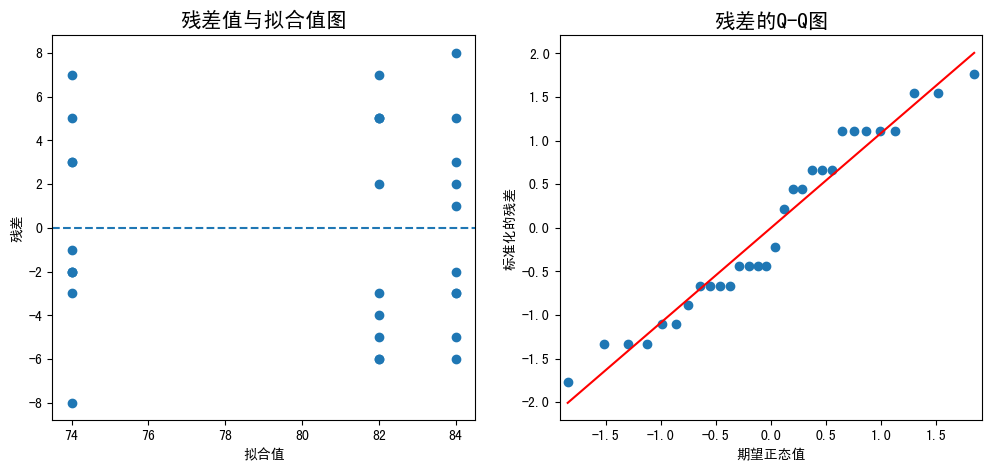

In [66]:
model = ols('产量 ~ 品种', data=example8_2).fit() # 拟合方差分析模型
plt.subplots(1, 2, figsize=(12, 5)) # 设置图形大小

plt.subplot(121) # 创建子图1
plt.scatter(model.fittedvalues, model.resid) # 绘制残差图
plt.xlabel('拟合值') # 添加横轴标签
plt.ylabel('残差') # 添加纵轴标签
plt.title('残差值与拟合值图', fontsize=15) # 添加子图标题
plt.axhline(0, ls='--') # 添加水平参考线

ax2 = plt.subplot(122) # 创建子图2
pplot = sm.ProbPlot(model.resid, fit=True) # 创建概率图对象
pplot.qqplot(line='r', ax=ax2, xlabel='期望正态值', ylabel='标准化的残差') # 绘制概率图
ax2.set_title('残差的Q-Q图', fontsize=15) # 添加子图标题

plt.show() # 显示图形

提出假设：
- $H_0: \sigma^2_1 = \sigma^2_2 = \cdots = \sigma^2_I$ (产量的方差齐性成立)
- $H_1: \sigma^2_1, \sigma^2_2, \cdots, \sigma^2_I$ 不全相等 (产量的方差齐性不成立)

In [15]:
example8_4 = pd.read_csv('./pydata/chap08/example8_4.csv', encoding='gbk') # 读取数据
example8_4.head() # 显示前5行数据

,施肥方式,品种,产量
0,甲,品种1,81
1,甲,品种1,82
2,甲,品种1,79
3,甲,品种1,81
4,甲,品种1,78


In [16]:
sample1 = example8_4.loc[example8_4['品种']=='品种1', '产量'].values # 品种1的产量数据
sample2 = example8_4.loc[example8_4['品种']=='品种2', '产量'].values # 品种2的产量数据
sample3 = example8_4.loc[example8_4['品种']=='品种3', '产量'].values # 品种3的产量数据

B, p_value = bartlett(sample1, sample2, sample3) # 执行Bartlett检验
print(f'统计量B={B:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量B=0.30152, p值=0.8601


In [17]:
sample1 = example8_4.loc[example8_4['施肥方式']=='甲', '产量'].values # 施肥方式甲的产量数据
sample2 = example8_4.loc[example8_4['施肥方式']=='乙', '产量'].values # 施肥方式乙的产量数据

B, p_value = bartlett(sample1, sample2) # 执行Bartlett检验
print(f'统计量B={B:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量B=0.42431, p值=0.5148


由于P>0.05，所以不能拒绝原假设。

In [18]:
sample1 = example8_4.loc[example8_4['品种']=='品种1', '产量'].values # 品种1的产量数据
sample2 = example8_4.loc[example8_4['品种']=='品种2', '产量'].values # 品种2的产量数据
sample3 = example8_4.loc[example8_4['品种']=='品种3', '产量'].values # 品种3的产量数据

F, p_value = levene(sample1, sample2, sample3) # 执行Levene检验
print(f'统计量F={F:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量F=0.92919, p值=0.4071


In [20]:
sample1 = example8_4.loc[example8_4['施肥方式']=='甲', '产量'].values # 施肥方式甲的产量数据
sample2 = example8_4.loc[example8_4['施肥方式']=='乙', '产量'].values # 施肥方式乙的产量数据

F, p_value = levene(sample1, sample2) # 执行Levene检验
print(f'统计量F={F:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量F=0.23228, p值=0.6336


由于P>0.05，所以不能拒绝原假设。

## 习题

### 8.1

In [2]:
df = pd.read_csv('./exercise/chap08/exercise8_1.csv', encoding='gbk') # 读取数据
df

,机器1,机器2,机器3,机器4
0,4.05,3.99,3.97,4.00
1,4.01,4.02,3.98,4.02
2,4.02,4.01,3.97,3.99
3,4.04,3.99,3.95,4.01
4,4.00,4.00,4.02,4.00
5,4.03,4.05,4.00,4.03


In [5]:
# (1) 检验机器对装填量是否有显著影响（α=0.01）。
df_melt = pd.melt(
    df, value_vars=['机器1', '机器2', '机器3', '机器4'], 
    value_name='装填量', var_name='机器'
) # 数据转换
df_melt.head() # 显示前5行数据

,机器,装填量
0,机器1,4.05
1,机器1,4.01
2,机器1,4.02
3,机器1,4.04
4,机器1,4.00


提出假设：
- $H_0: \alpha_1 = \alpha_2 = \alpha_3 = \alpha_4 = 0$(机器对装填量的影响不显著)
- $H_1: \alpha_1, \alpha_2, \alpha_3, \alpha_4$ 至少有一个不等于0(机器对装填量的影响显著)

In [8]:
model = ols('装填量 ~ 机器', data=df_melt).fit() # 拟合方差分析模型
anova_table = anova_lm(model, typ=1) # 方差分析表
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F)
机器,3.0,0.005846,0.001949,4.575995,0.013485
Residual,20.0,0.008517,0.000426,NaN,NaN


由于P>0.01, 所以不能拒绝原假设。

In [9]:
model.summary() # 显示模型汇总信息

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    装填量   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     4.576
Date:                Tue, 16 May 2023   Prob (F-statistic):             0.0135
Time:                        10:28:24   Log-Likelihood:                 61.271
No. Observations:                  24   AIC:                            -114.5
Df Residuals:                      20   BIC:                            -109.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0250      0.008    477.773      0.000       4.007       4.043
机器[T.机器2]     -0.0150      0.012     -1.259      0.223      -0.040       0.010
机器[T.机器3]     -0.0433      0.012     -3.637      0.002      -0.068      -0.018
机器[T.机器4]     -0.0167      0.012     -1.399      0.177      -0.042       0.008
==============================================================================
Omnibus:                        1.421   Durbin-Watson:                   2.490
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                1.277
Skew:                           0.499   Prob(JB):                        0.528
Kurtosis:                       2.468   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# (2) 分析效应量
print(f'效应量为 {model.rsquared:.4g}') # 显示效应量

效应量为 0.407


In [12]:
# (3) 采用HSD方法比较哪些机器的装填量之间存在显著差异。
mc = MultiComparison(df_melt['装填量'], df_melt['机器']) # 创建多重比较对象
mc.tukeyhsd(alpha=0.01).summary() # 执行多重比较

group1,group2,meandiff,p-adj,lower,upper,reject
机器1,机器2,-0.015,0.5982,-0.0573,0.0273,False
机器1,机器3,-0.0433,0.0082,-0.0856,-0.0011,True
机器1,机器4,-0.0167,0.5144,-0.0589,0.0256,False
机器2,机器3,-0.0283,0.114,-0.0706,0.0139,False
机器2,机器4,-0.0017,0.999,-0.0439,0.0406,False
机器3,机器4,0.0267,0.1471,-0.0156,0.0689,False


结果显示，机器1与机器3之间的差异显著，其余两两之间的差异均不显著。

提出正态性假设：
- $H_0:$ 装填量服从正态分布
- $H_1:$ 装填量不服从正态分布

In [21]:
# (4) 检验装填量是否满足正态性和方差齐性。
# S-W检验
W, p_value = shapiro(df_melt['装填量']) # 执行S-W检验
print(f'统计量W={W:.5f}, p值={p_value:.4g}') # 显示检验结果

# K-S检验
D, p_value = kstest(
    df_melt['装填量'], 'norm', alternative='two-sided', mode='asymp',
    args=(df_melt['装填量'].mean(), df_melt['装填量'].std())
) # 执行K-S检验
print(f'统计量D={D:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量W=0.97509, p值=0.7912
统计量D=0.10958, p值=0.9354


由于P>0.05，所以不能拒绝原假设。

提出方差齐性假设：
- $H_0: \sigma^2_1 = \sigma^2_2 = \sigma^2_3 = \sigma^2_4$ (装填量的方差齐性成立)
- $H_1: \sigma^2_1, \sigma^2_2, \sigma^2_3, \sigma^2_4$ 不全相等 (装填量的方差齐性不成立)

In [22]:
sample1 = df_melt.loc[df_melt['机器']=='机器1', '装填量'].values # 机器1的装填量数据
sample2 = df_melt.loc[df_melt['机器']=='机器2', '装填量'].values # 机器2的装填量数据
sample3 = df_melt.loc[df_melt['机器']=='机器3', '装填量'].values # 机器3的装填量数据
sample4 = df_melt.loc[df_melt['机器']=='机器4', '装填量'].values # 机器4的装填量数据

# Bartlett检验
B, p_value = bartlett(sample1, sample2, sample3, sample4) # 执行Bartlett检验
print(f'统计量B={B:.5f}, p值={p_value:.4g}') # 显示检验结果

# Levene检验
F, p_value = levene(sample1, sample2, sample3, sample4) # 执行Levene检验
print(f'统计量F={F:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量B=1.39265, p值=0.7073
统计量F=0.30864, p值=0.8189


由于P>0.05，所以不能拒绝原假设。

### 8.2

In [23]:
df = pd.read_csv('./exercise/chap08/exercise8_2.csv', encoding='gbk') # 读取数据
df

,高层管理者,中层管理者,低层管理者
0,7,8,5
1,7,9,6
2,8,8,5
3,7,10,7
4,9,9,4
5,8,10,8


In [25]:
# (1) 检验管理者的水平不同是否会导致评分的显著差异（α=0.05），并分析效应量。
df_melt = pd.melt(
    df, value_vars=['高层管理者', '中层管理者', '低层管理者'],
    value_name='满意度得分', var_name='管理者'
) # 数据转换
df_melt.head() # 显示前5行数据

,管理者,满意度得分
0,高层管理者,7
1,高层管理者,7
2,高层管理者,8
3,高层管理者,7
4,高层管理者,9


提出假设：
- $H_0: \alpha_1 = \alpha_2 = \alpha_3 = 0$(管理者类型对满意度评分的影响不显著)
- $H_1: \alpha_1, \alpha_2, \alpha_3$ 至少有一个不等于0(管理者类型对满意度评分的影响显著)

In [26]:
model = ols('满意度得分 ~ 管理者', data=df_melt).fit() # 拟合方差分析模型
anova_table = anova_lm(model, typ=1) # 方差分析表
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F)
管理者,2.0,30.333333,15.166667,12.522936,0.000633
Residual,15.0,18.166667,1.211111,NaN,NaN


由于P<0.05, 所以拒绝原假设。

In [27]:
model.summary() # 显示模型汇总信息

/home/zmy/mambaforge/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  满意度得分   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     12.52
Date:                Tue, 16 May 2023   Prob (F-statistic):           0.000633
Time:                        10:45:58   Log-Likelihood:                -25.624
No. Observations:                  18   AIC:                             57.25
Df Residuals:                      15   BIC:                             59.92
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.0000      0.449     20.032      0.000       8.042       9.958
管理者[T.低层管理者]    -3.1667      0.635     -4.984      0.000      -4.521      -1.812
管理者[T.高层管理者]    -1.3333      0.635     -2.098      0.053      -2.688       0.021
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   2.815
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.598
Skew:                           0.329   Prob(JB):                        0.742
Kurtosis:                       2.396   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
print(f'效应量为 {model.rsquared:.4g}') # 显示效应量

效应量为 0.6254


In [29]:
# (2) 采用HSD方法比较管理者的评分之间的差异。
mc = MultiComparison(df_melt['满意度得分'], df_melt['管理者']) # 创建多重比较对象
mc.tukeyhsd(alpha=0.05).summary() # 执行多重比较

group1,group2,meandiff,p-adj,lower,upper,reject
中层管理者,低层管理者,-3.1667,0.0005,-4.817,-1.5163,True
中层管理者,高层管理者,-1.3333,0.1238,-2.9837,0.317,False
低层管理者,高层管理者,1.8333,0.0288,0.183,3.4837,True


结果显示，中层管理者与低层管理者、低层管理者与高层管理者之间的差异显著，中层管理者与高层管理者之间的差异不显著。

提出正态性假设：
- $H_0:$ 满意度评分服从正态分布
- $H_1:$ 满意度评分不服从正态分布

In [30]:
# (3) 检验满意度评分是否满足正态性和方差齐性。
# S-W检验
W, p_value = shapiro(df_melt['满意度得分']) # 执行S-W检验
print(f'统计量W={W:.5f}, p值={p_value:.4g}') # 显示检验结果

# K-S检验
D, p_value = kstest(
    df_melt['满意度得分'], 'norm', alternative='two-sided', mode='asymp',
    args=(df_melt['满意度得分'].mean(), df_melt['满意度得分'].std())
) # 执行K-S检验
print(f'统计量D={D:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量W=0.94141, p值=0.3063
统计量D=0.17195, p值=0.6617


由于P>0.05，所以不能拒绝原假设。

提出方差齐性假设：
- $H_0: \sigma^2_1 = \sigma^2_2 = \sigma^2_3$ (满意度评分的方差齐性成立)
- $H_1: \sigma^2_1, \sigma^2_2, \sigma^2_3$ 不全相等 (满意度评分的方差齐性不成立)

In [31]:
sample1 = df_melt.loc[df_melt['管理者']=='高层管理者', '满意度得分'].values # 高层管理者满意度得分数据
sample2 = df_melt.loc[df_melt['管理者']=='中层管理者', '满意度得分'].values # 中层管理者满意度得分数据
sample3 = df_melt.loc[df_melt['管理者']=='低层管理者', '满意度得分'].values # 低层管理者满意度得分数据

# Bartlett检验
B, p_value = bartlett(sample1, sample2, sample3) # 执行Bartlett检验
print(f'统计量B={B:.5f}, p值={p_value:.4g}') # 显示检验结果

# Levene检验
F, p_value = levene(sample1, sample2, sample3) # 执行Levene检验
print(f'统计量F={F:.5f}, p值={p_value:.4g}') # 显示检验结果

统计量B=1.97464, p值=0.3726
统计量F=1.36364, p值=0.2857


由于P>0.05，所以不能拒绝原假设。

### 8.3

In [32]:
df = pd.read_csv('./exercise/chap08/exercise8_3.csv', encoding='gbk') # 读取数据
df

,实验号,企业A,企业B,企业C
0,1,50,32,45
1,2,50,28,42
2,3,43,30,38
3,4,40,34,48
4,5,39,26,40


In [34]:
# (1) 分析3个企业生产的电池平均使用寿命之间有无显著差异（α=0.05），并分析效应量。
df_melt = pd.melt(
    df, value_vars=['企业A', '企业B', '企业C'],
    value_name='电池使用寿命', var_name='企业'
) # 数据转换
df_melt.head() # 显示前5行数据

,企业,电池使用寿命
0,企业A,50
1,企业A,50
2,企业A,43
3,企业A,40
4,企业A,39


提出假设：
- $H_0: \alpha_1 = \alpha_2 = \alpha_3 = 0$(企业对电池使用寿命的影响不显著)
- $H_1: \alpha_1, \alpha_2, \alpha_3$ 至少有一个不等于0(企业对电池使用寿命的影响显著)

In [35]:
model = ols('电池使用寿命 ~ 企业', data=df_melt).fit() # 拟合方差分析模型
anova_table = anova_lm(model, typ=1) # 方差分析表
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F)
企业,2.0,615.6,307.800000,17.068392,0.00031
Residual,12.0,216.4,18.033333,NaN,NaN


由于P<0.05, 所以拒绝原假设。

In [36]:
# (2) 如果有差异，用HSD方法检验哪些企业之间有差异。
mc = MultiComparison(df_melt['电池使用寿命'], df_melt['企业']) # 创建多重比较对象
mc.tukeyhsd(alpha=0.05).summary() # 执行多重比较

group1,group2,meandiff,p-adj,lower,upper,reject
企业A,企业B,-14.4,0.0005,-21.5653,-7.2347,True
企业A,企业C,-1.8,0.7847,-8.9653,5.3653,False
企业B,企业C,12.6,0.0014,5.4347,19.7653,True


结果显示，企业A与企业B、企业B与企业C之间的差异显著，企业A与企业C之间的差异不显著。

### 8.4

In [37]:
df = pd.read_csv('./exercise/chap08/exercise8_4.csv', encoding='gbk') # 读取数据
df

,品种,施肥方案1,施肥方案2,施肥方案3,施肥方案4
0,1,12.0,9.5,10.4,9.7
1,2,13.7,11.5,12.4,9.6
2,3,14.3,12.3,11.4,11.1
3,4,14.2,14.0,12.5,12.0
4,5,13.0,14.0,13.1,11.4


In [38]:
# (1) 检验不同品种和施肥方案对产量的影响是否显著（α=0.05）。
df_melt = pd.melt(
    df, id_vars=['品种'], value_vars=['施肥方案1', '施肥方案2', '施肥方案3', '施肥方案4'],
    value_name='产量', var_name='施肥方案'
) # 数据转换
df_melt.head() # 显示前5行数据

,品种,施肥方案,产量
0,1,施肥方案1,12.0
1,2,施肥方案1,13.7
2,3,施肥方案1,14.3
3,4,施肥方案1,14.2
4,5,施肥方案1,13.0


提出对于品种的假设：
- $H_0: \alpha_1 = \cdots = \alpha_i, i = 1, 2, 3, 4, 5$(品种对产量的影响不显著) 
- $H_1: \alpha_1, \cdots, \alpha_i$ 不全相等(品种对产量的影响显著)

提出对于施肥方案的假设：
- $H_0: \beta_1 = \cdots = \beta_j, j = 1, 2, 3, 4$(施肥方案对产量的影响不显著)
- $H_1: \beta_1, \cdots, \beta_j$ 不全相等(施肥方案对产量的影响显著)


In [48]:
model = ols('产量 ~ C(品种) + 施肥方案', data=df_melt).fit() # 拟合方差分析模型
anova_table = anova_lm(model, typ=1) # 方差分析表
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F)
C(品种),4.0,19.0670,4.766750,7.239716,0.003315
施肥方案,3.0,18.1815,6.060500,9.204658,0.001949
Residual,12.0,7.9010,0.658417,NaN,NaN


由于P<0.05, 所以均拒绝原假设。

In [43]:
model.summary() # 显示模型汇总信息

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     产量   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     8.082
Date:                Tue, 16 May 2023   Prob (F-statistic):           0.000955
Time:                        11:06:20   Log-Likelihood:                -19.091
No. Observations:                  20   AIC:                             54.18
Df Residuals:                      12   BIC:                             62.15
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.7350      0.513     22.867      0.000      10.617      12.853
C(品种)[T.2]        1.4000      0.574      2.440      0.031       0.150       2.650
C(品种)[T.3]        1.8750      0.574      3.268      0.007       0.625       3.125
C(品种)[T.4]        2.7750      0.574      4.836      0.000       1.525       4.025
C(品种)[T.5]        2.4750      0.574      4.314      0.001       1.225       3.725
施肥方案[T.施肥方案2]    -1.1800      0.513     -2.299      0.040      -2.298      -0.062
施肥方案[T.施肥方案3]    -1.4800      0.513     -2.884      0.014      -2.598      -0.362
施肥方案[T.施肥方案4]    -2.6800      0.513     -5.222      0.000      -3.798      -1.562
==============================================================================
Omnibus:                        1.845   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.241
Skew:                          -0.353   Prob(JB):                        0.538
Kurtosis:                       2.004   Cond. No.                         6.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# (2) 计算偏效应量并进行分析。
anova_table['eta_sq_part'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table.loc['Residual', 'sum_sq']) # 计算偏效应量
anova_table.loc['Residual', 'eta_sq_part'] = np.nan # 将残差的偏效应量设置为缺失值
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F),eta_sq_part
C(品种),4.0,19.0670,4.766750,7.239716,0.003315,0.707023
施肥方案,3.0,18.1815,6.060500,9.204658,0.001949,0.697077
Residual,12.0,7.9010,0.658417,NaN,NaN,NaN


偏效应分析结果表明：
- 在排除施肥方案的影响后，品种因子解释了产量误差的70.70%
- 在排除品种的影响后，施肥方案因子解释了产量误差的69.71%

### 8.5

In [50]:
df = pd.read_csv('./exercise/chap08/exercise8_5.csv', encoding='gbk') # 读取数据
df

,时段,路段1,路段2,路段3
0,高峰期,36.5,28.1,32.4
1,高峰期,34.1,29.9,33.0
2,高峰期,37.2,32.2,36.2
3,高峰期,35.6,31.5,35.5
4,高峰期,38.0,30.1,35.1
5,非高峰期,30.6,27.6,31.8
6,非高峰期,27.9,24.3,28.0
7,非高峰期,32.4,22.0,26.7
8,非高峰期,31.8,25.4,29.3
9,非高峰期,27.3,21.7,25.6


In [51]:
# (1) 分析路段、时段以及路段与时段交互作用对行车时间的影响（α=0.05）。
df_melt = pd.melt(
    df, id_vars=['时段'], value_vars=['路段1', '路段2', '路段3'],
    value_name='行车时间', var_name='路段'
) # 数据转换
df_melt.head() # 显示前5行数据

,时段,路段,行车时间
0,高峰期,路段1,36.5
1,高峰期,路段1,34.1
2,高峰期,路段1,37.2
3,高峰期,路段1,35.6
4,高峰期,路段1,38.0


提出对于时段的假设：
- $H_0: \alpha_1 = \alpha_2 = 0$(时段对行车时间的影响不显著)
- $H_1: \alpha_1, \alpha_2$ 至少有一个不等于0(时段对行车时间的影响显著)

提出对于路段的假设：
- $H_0: \beta_1 = \beta_2 = \beta_3 = 0$(路段对行车时间的影响不显著)
- $H_1: \beta_1, \beta_2, \beta_3$ 至少有一个不等于0(路段对行车时间的影响显著)

提出对于时段与路段交互作用的假设：
- $H_0: \gamma_{ij} = 0, i = 1, 2, j = 1, 2, 3$(时段与路段交互作用对行车时间的影响不显著)
- $H_1: \gamma_{ij}$ 至少有一个不等于0(时段与路段交互作用对行车时间的影响显著) 

In [53]:
model = ols('行车时间 ~ 时段 + 路段 + 时段:路段', data=df_melt).fit() # 拟合方差分析模型
anova_table = anova_lm(model, typ=1) # 方差分析表
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F)
时段,1.0,288.300000,288.300000,70.331368,1.355779e-08
路段,2.0,180.514667,90.257333,22.018459,3.711926e-06
时段:路段,2.0,0.024000,0.012000,0.002927,9.970772e-01
Residual,24.0,98.380000,4.099167,NaN,NaN


结果显示：
- 对于时段、路段效应检验，P<0.05，所以拒绝原假设。
- 对于交互作用效应检验，P>0.05，所以不能拒绝原假设。

In [54]:
model.summary() # 显示模型汇总信息

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   行车时间   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     22.87
Date:                Tue, 16 May 2023   Prob (F-statistic):           2.07e-08
Time:                        11:22:03   Log-Likelihood:                -60.383
No. Observations:                  30   AIC:                             132.8
Df Residuals:                      24   BIC:                             141.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              30.0000      0.905     33.133      0.000      28.131      31.869
时段[T.高峰期]               6.2800      1.280      4.904      0.000       3.637       8.923
路段[T.路段2]              -5.8000      1.280     -4.529      0.000      -8.443      -3.157
路段[T.路段3]              -1.7200      1.280     -1.343      0.192      -4.363       0.923
时段[T.高峰期]:路段[T.路段2]    -0.1200      1.811     -0.066      0.948      -3.857       3.617
时段[T.高峰期]:路段[T.路段3]    -0.1200      1.811     -0.066      0.948      -3.857       3.617
==============================================================================
Omnibus:                        2.972   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                1.391
Skew:                           0.078   Prob(JB):                        0.499
Kurtosis:                       1.957   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# (2) 计算偏效应量并进行分析。
anova_table['eta_sq_part'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table.loc['Residual', 'sum_sq']) # 计算偏效应量
anova_table.loc['Residual', 'eta_sq_part'] = np.nan # 将残差的偏效应量设置为缺失值
anova_table # 显示方差分析表

,df,sum_sq,mean_sq,F,PR(>F),eta_sq_part
时段,1.0,288.300000,288.300000,70.331368,1.355779e-08,0.745578
路段,2.0,180.514667,90.257333,22.018459,3.711926e-06,0.647250
时段:路段,2.0,0.024000,0.012000,0.002927,9.970772e-01,0.000244
Residual,24.0,98.380000,4.099167,NaN,NaN,NaN


偏效应分析结果表明：
- 在排除路段和交互效应的影响后，时段因子解释了行车时间误差的74.56%
- 在排除时段和交互效应的影响后，路段因子解释了行车时间误差的64.73%
- 在排除时段和路段的影响后，交互效应因子解释了行车时间误差的0.024%